# Visual tests.

## Plot DM structure for different halos.

In [1]:
from shared.preface import *
import shared.functions as fct


PRE = PRE(
    sim='L012N376', 
    z0_snap=36, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=10, thetas=10, vels=100,
    pre_CPUs=1, sim_CPUs=6
)

# Make temporary folder to store files, s.t. parallel runs don't clash.
rand_code = ''.join(
    random.choices(string.ascii_uppercase + string.digits, k=4)
)
TEMP_DIR = f'{PRE.OUT_DIR}/temp_data_{rand_code}'
os.makedirs(TEMP_DIR)

Testing=False
if Testing:
    mass_gauge = 12.3
    mass_range = 0.3
    size = 1
else:
    mass_gauge = 12.0
    mass_range = 0.6
    size = 10

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, TEMP_DIR
)
halo_batch_IDs = np.load(f'{TEMP_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{TEMP_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')


for halo_j, halo_ID in enumerate(halo_batch_IDs[:1]):

    # Manually adjust DM inclusion radius and number of halos.
    # (for manual job submissions on snellius)
    Rvir_halo = halo_batch_params[halo_j,0]
    Rvir_multiplier = 4  # 2,4,8,16 x Rvir
    DM_range_kpc = Rvir_multiplier*Rvir_halo*kpc  
    halos_inRange_lim = 2

    # '''
    # =============================================== #
    # Run precalculations for selected halo in batch. #
    # =============================================== #

    # Generate progenitor index array for current halo.
    splits = re.split('/', SIM_TYPE)
    MTname = f'{PRE.SIM}_{splits[0]}_{splits[1]}'
    proj_IDs = fct.read_MergerTree(PRE.OUT_DIR, MTname, halo_ID)


    # for j, (snap, proj_ID) in enumerate(zip(
    #     PRE.NUMS_SNAPS[::-1], proj_IDs
    # )):

    # For snapshot 0036 at z=0.
    snap, proj_ID = PRE.NUMS_SNAPS[-1], proj_IDs[0]
    proj_ID = int(proj_ID)

    print(f'halo {halo_j+1}/{halo_num} ; snapshot {snap}')
    

    # --------------------------- #
    # Read and load DM positions. #
    # --------------------------- #

    IDname = f'origID{halo_ID}_snap_{snap}'
    fct.read_DM_halos_inRange(
        snap, proj_ID, DM_range_kpc, int(halos_inRange_lim), 
        IDname, PRE.SIM_DIR, TEMP_DIR, PRE.PRE_CPUs
    )
    DM_raw = np.load(f'{TEMP_DIR}/DM_pos_{IDname}.npy')


# Remove temporary folder with all individual neutrino files.
shutil.rmtree(TEMP_DIR)

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('cornflowerblue')
ax = fig.add_subplot(111, projection='3d')
# ax.patch.set_facecolor('cornflowerblue')
bubble_cmap = cc.cm.CET_D7  # blue-to-yellow, medium dark middle

print(len(DM_raw))
x_DM, y_DM, z_DM = DM_raw[:,0], DM_raw[:,1], DM_raw[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
ax.scatter(x, y, z, alpha=0.6, c='blueviolet', s=0.2, label='DM particles')
plt.show()

## Test adaptive DM_lim implementation.

In [ ]:
# ---------------------- #
# Cell division process. #
# ---------------------- #

# Make temporary folder to store files, s.t. parallel runs don't clash.
rand_code = ''.join(
    random.choices(string.ascii_uppercase + string.digits, k=4)
)
TEMP_DIR = f'{PRE.OUT_DIR}/temp_data_{rand_code}'
os.makedirs(TEMP_DIR)


# Initialize grid.
snap_GRID_L = (int(np.abs(DM_raw).max()) + 1)*kpc
raw_grid = fct.grid_3D(snap_GRID_L, snap_GRID_L)
init_grid = np.expand_dims(raw_grid, axis=1)

# Prepare arrays for cell division.
DM_raw *= kpc
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos_for_cell_division = np.repeat(DM_pos, len(init_grid), axis=0)

# Cell division.
cell_division_count = fct.cell_division(
    init_grid, DM_pos_for_cell_division, snap_GRID_L, PRE.DM_LIM, None, TEMP_DIR, IDname
)

# Load files from cell division.
fin_grid = np.load(f'{TEMP_DIR}/fin_grid_{IDname}.npy')
DM_count = np.load(f'{TEMP_DIR}/DM_count_{IDname}.npy')
cell_com = np.load(f'{TEMP_DIR}/cell_com_{IDname}.npy')
cell_gen = np.load(f'{TEMP_DIR}/cell_gen_{IDname}.npy')


# Remove temporary folder.
shutil.rmtree(TEMP_DIR)

print(fin_grid.shape)


# Plot grid over DM.
fig = plt.figure()
fig.patch.set_facecolor('cornflowerblue')
ax = fig.add_subplot(111, projection='3d')

plot_grid = np.squeeze(fin_grid, axis=1) / kpc
xg, yg, zg = plot_grid[:,0], plot_grid[:,1], plot_grid[:,2] 
ax.scatter(
    xg, yg, zg, s=1, marker='x', color='black', 
    alpha=1, label='Cell centers'
)
plt.show()

# Number density plots for spheres.

In [1]:
from shared.preface import *
import shared.functions as fct

# Initialize parameters and files.
PRE_SIM = PRE(
    sim='L012N376', 
    z0_snap=62, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=20, thetas=20, vels=200,
)

mass_gauge = 12.0
mass_range = 0.6
halo_num = 7

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'


# Load data for MW halo only of smooth simulation.
PRE_SMOOTH = PRE(
    sim='LinfNinf', phis=10, thetas=10, vels=100, MW_HALO=True
)

smooth_name = f'{PRE_SMOOTH.NUS}nus_smooth_{PRE_SMOOTH.HALOS}_{SOLVER}'
smooth_dir = f'{os.getcwd()}/{PRE_SMOOTH.SIM}'
u_all_MW = fct.load_sim_data(smooth_dir, smooth_name, 'velocities')

smooth_output = f'{smooth_dir}/number_densities_{smooth_name}.npy'
fct.number_densities_mass_range(
    u_all_MW, NU_MRANGE, smooth_output, 
    average=False, m_start=0.01, z_start=0.5
)
etas_smooth = np.load(f'{smooth_output}')/N0

********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 20, THETAs=20, Vs=200
Total neutrinos: 80000
# Simulation parameters:
Simulation box: L012N376
Snapshot from 0062 (z=0) to 0013 (z=4)
Pre/Sim CPUs 0/0
DM limit for cells: 1000
# File management:
Box files directory: 
 /home/fabian/ownCloud/snellius/L012N376/DMONLY/CDM_TF50
Output directory: 
 /home/fabian/my_github_projects/neutrino_clustering_V2/L012N376/DMONLY/CDM_TF50
**********************************************************
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: LinfNinf
Sim CPUs 0
Output directory: 
 /home/fabian/my_github_projects/neutrino_clustering_V2/LinfNinf
Halos in smooth sim: MW
**********************************************************


(7, 100)


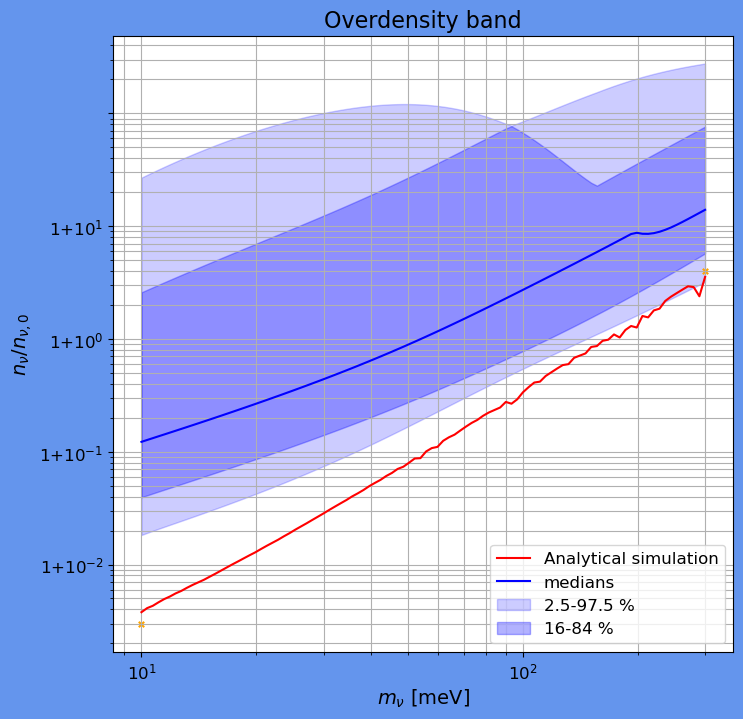

(7, 100)


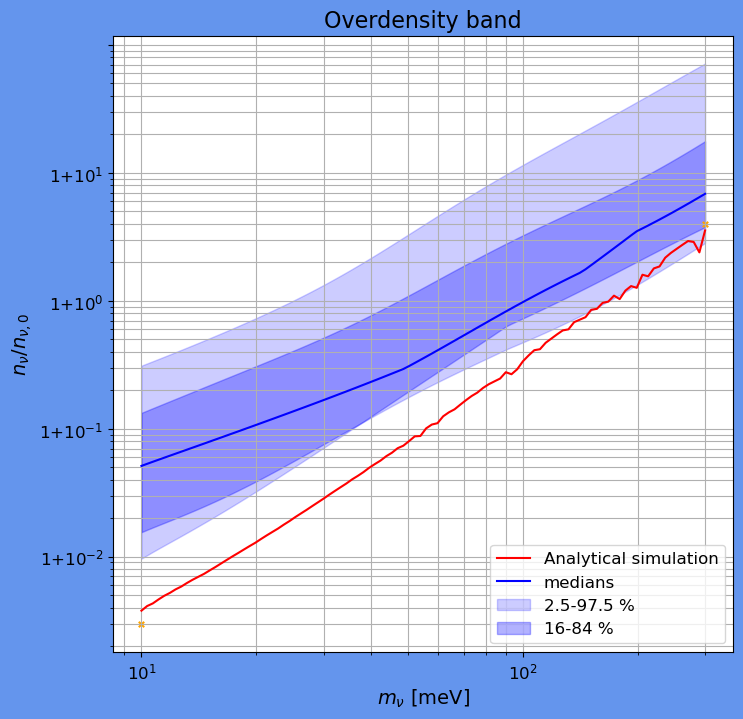

(7, 100)


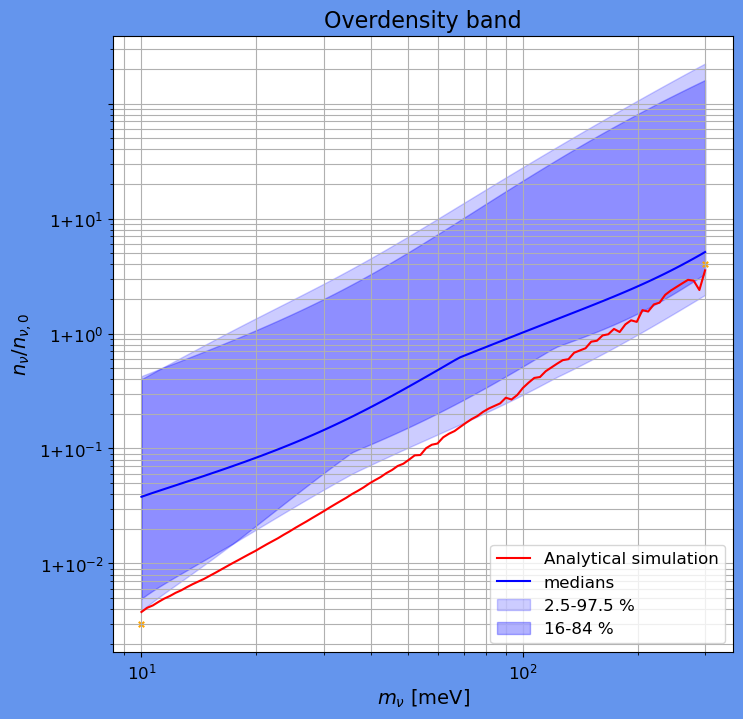

(7, 100)


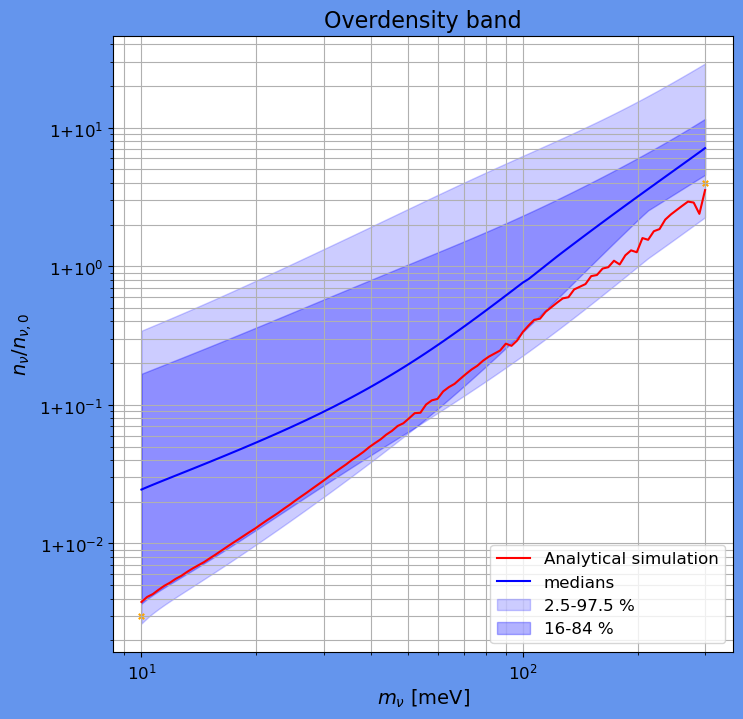

In [2]:
shells = 4
for si in range(shells):
    etas_spheres = []
    for halo_j in range(7):

        # Load overdensities of current halo for current spheres.
        Sname = f'{PRE_SIM.NUS}nus_{hname}_halo{halo_j}_sphere_{si+1}shells'
        out_file = f'{PRE_SIM.OUT_DIR}/number_densities_{Sname}.npy'
        etas_spheres.append(np.load(f'{out_file}')/N0)

    etas_sim = np.array(etas_spheres)
    print(etas_sim.shape)

    fig_dir = f'{os.getcwd()}/figures'
    splits = re.split('/', SIM_TYPE)
    fname = f'{splits[0]}_{splits[1]}_{hname}_{si+1}shells'
    fct.plot_eta_band(
        etas_sim, etas_smooth, NU_MRANGE, fig_dir, fname, 
        show=True, Mertsch=True
    )

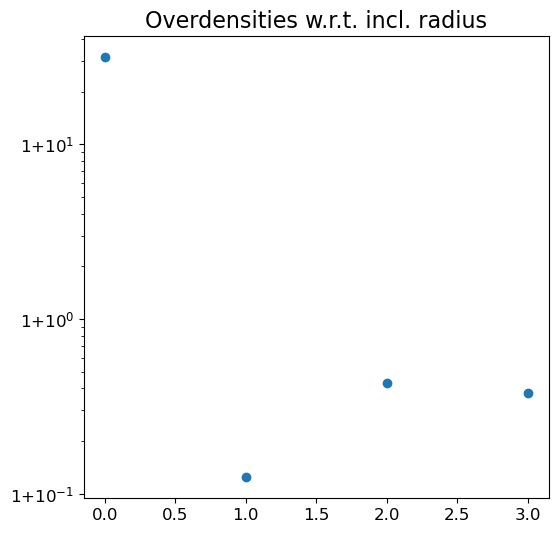

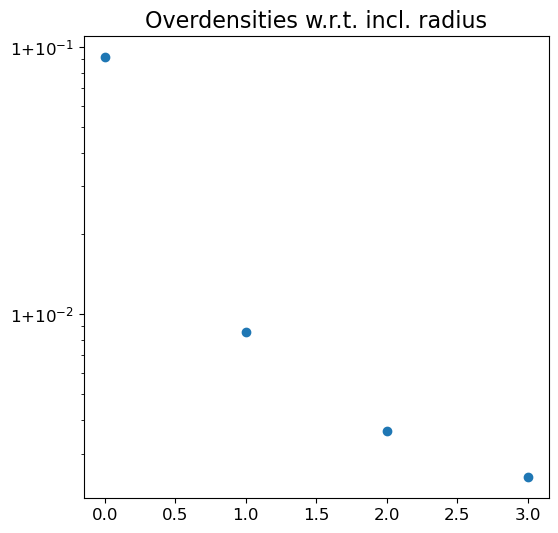

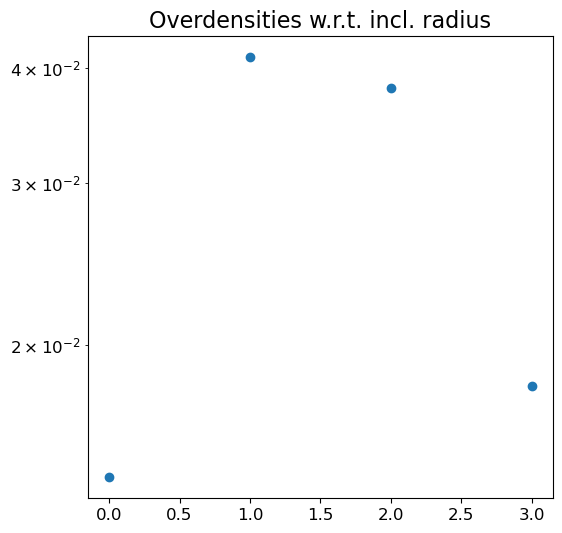

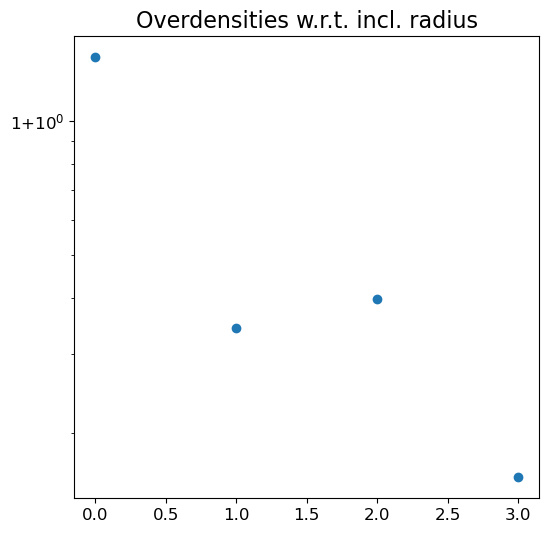

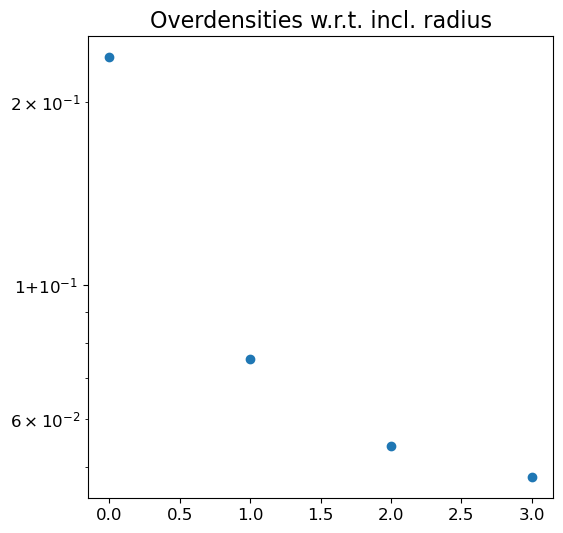

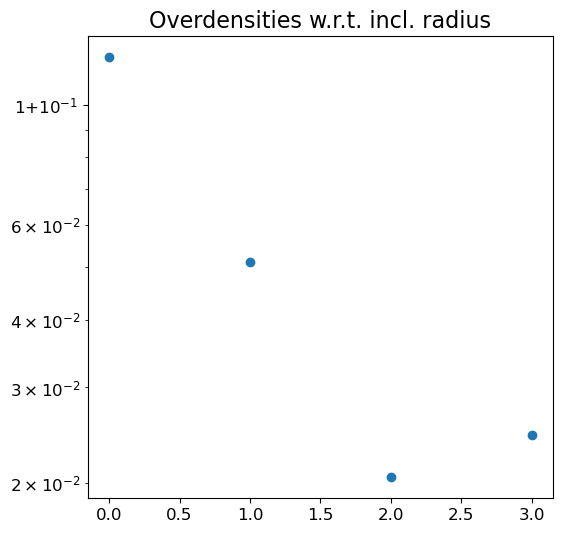

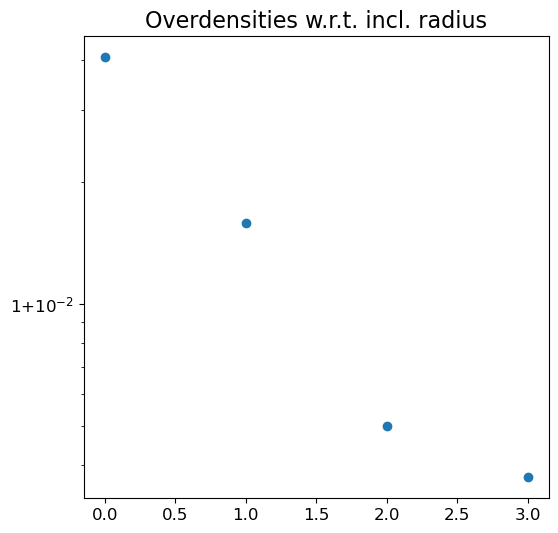

In [36]:
shells = 4
for halo_j in range(7):
    etas_1halo = []
    for si in range(shells):

        # Load overdensities of selected halo for current spheres.
        # halo_j = 0
        Sname = f'{PRE_SIM.NUS}nus_{hname}_halo{halo_j}_sphere_{si+1}shells'
        out_file = f'{PRE_SIM.OUT_DIR}/number_densities_{Sname}.npy'
        etas_1halo.append(np.load(f'{out_file}')/N0)

    etas_1mass = np.array(etas_1halo)[:,0]  # change neutrino mass here
    x_spheres = np.arange(shells)
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.scatter(x_spheres, etas_1mass-1)

    ax.set_title('Overdensities w.r.t. incl. radius')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))
    plt.show()